In [6]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from skimage.filters import gabor


In [20]:
def enhance_image(image):
    image = np.uint8(image)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    # sharpened_image = np.uint8(np.clip(enhanced_image - 0.3 * laplacian, 0, 255))

    normalized_image = cv2.normalize(
        sharpened_image,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    # wiener_image = cv2.ximgproc.dt_filter(scaled_image, dDepth=-1, ksize=3)

    wiener_image = cv2.blur(sharpened_image, (3, 3))

    # return normalized_image
    return wiener_image

<Axes: title={'center': 'Image pixel distribution'}, ylabel='Frequency'>

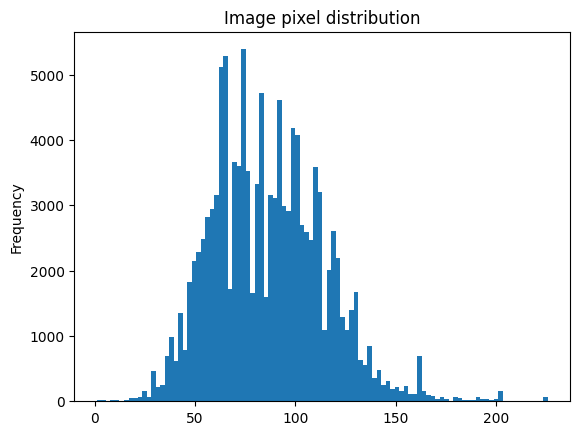

In [21]:
non_zero_values = im.flatten()[im.flatten() != 0]

pd.Series(non_zero_values).plot(kind="hist", bins=100, title="Image pixel distribution")

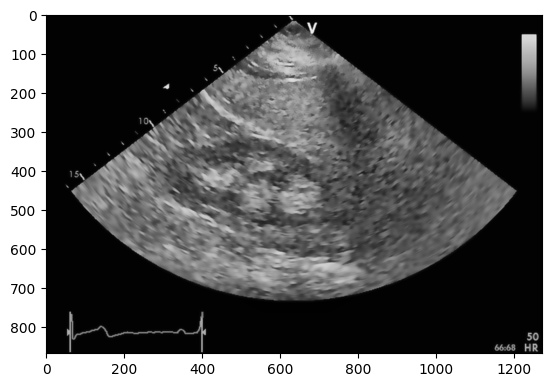

In [22]:
eh_im = enhance_image(im)

plt.imshow(eh_im, cmap="grey")

## Setting up dataset and creating image files

In [23]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        enhanced_im = enhance_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enhanced_im[300:700, 170:800]

        # to save images:
        # plt.imsave(f"og/{filename}", im.astype(np.uint8), cmap="grey")
        # plt.imsave(f"enh/{filename}", enhanced_im, cmap="grey")
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey")
        roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        data_records["images"].append(roi_im)
        # data_records["images"].append(enhanced_im)


df = pd.DataFrame(data_records)

In [24]:
df["images"][0].shape

(400, 630)

### GLCM features

In [25]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):

    image = image.astype(np.uint8)
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )

    # Compute GLCM properties
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [26]:
images = df["images"].values

# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)

In [27]:
y = df["class"]

In [28]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [29]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


def get_best_model(X, y, pca, num_folds=7):

    # Define the number of folds for cross-validation
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    # Calculate the mean accuracy score across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print("Mean Accuracy:", mean_accuracy)
    print("Best Accuracy:", max(accuracy_scores))

    # Print average ROC-AUC score
    mean_auc = np.mean(auc_scores)
    print("Mean ROC-AUC Score:", mean_auc)

    # Print average confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    print("Mean Confusion Matrix:\n", mean_conf_matrix)

    class_names = ["No Disease", "Disease"]

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        mean_conf_matrix,
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(
        "Mean Classification Report:\n", classification_reports[0]
    )  # Assuming same report for all folds

    return clf

Mean Accuracy: 0.943200936288494
Best Accuracy: 0.9841269841269841
Mean ROC-AUC Score: 0.9150793650793653
Mean Confusion Matrix:
 [[15.28571429  2.71428571]
 [ 0.85714286 44.        ]]


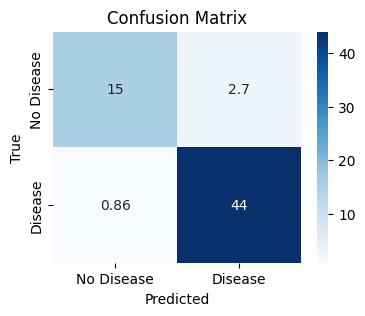

Mean Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.89      0.93      0.91        45

    accuracy                           0.87        63
   macro avg       0.85      0.83      0.84        63
weighted avg       0.87      0.87      0.87        63



In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=42
)
# Initialize a PCA object
pca = PCA(n_components=11)
model = get_best_model(X_train, y_train, pca, 7)

# Mean Accuracy: 0.943200936288494
# Best Accuracy: 0.9841269841269841
# Mean ROC-AUC Score: 0.9150793650793653
# Mean Confusion Matrix:
#  [[15.28571429  2.71428571]
#  [ 0.85714286 44.        ]]

Test Accuracy: 0.9181818181818182


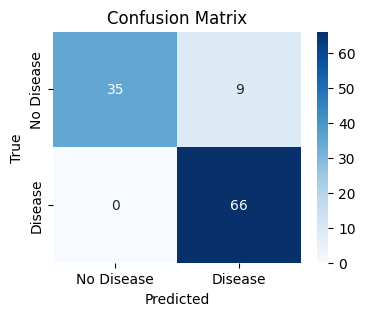

In [31]:
import seaborn as sns

# Evaluate the model on the testing data
pca.fit_transform(X_train)
X_test = pca.transform(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
class_names = ["No Disease", "Disease"]
plt.figure(figsize=(4, 3))
sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 0.9181

PCA(MLE) gives better accuracy and stuff that any other methods

In [32]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


def get_best_model1(X, y, pca, num_folds=7):

    # Define the number of folds for cross-validation
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a PCA object

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )
    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    # Calculate the mean accuracy score across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print("Mean Accuracy:", mean_accuracy)
    print("Best Accuracy:", max(accuracy_scores))

    # Print average ROC-AUC score
    mean_auc = np.mean(auc_scores)
    print("Mean ROC-AUC Score:", mean_auc)

    # Print average confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    print("Mean Confusion Matrix:\n", mean_conf_matrix)

    class_names = ["No Disease", "Disease"]

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        mean_conf_matrix,
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("Explained Variance Ratio:", sum(pca.explained_variance_ratio_))

    # Print average classification report
    print("Mean Classification Report:\n", classification_reports[0])

    print(accuracy_scores)
    return clf

Mean Accuracy: 0.9454319362153463
Best Accuracy: 0.9841269841269841
Mean ROC-AUC Score: 0.9071428571428571
Mean Confusion Matrix:
 [[14.71428571  3.28571429]
 [ 0.14285714 44.71428571]]


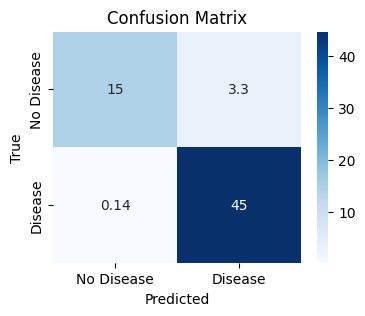

Explained Variance Ratio: 1.0000000000000002
Mean Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.92      1.00      0.96        45

    accuracy                           0.94        63
   macro avg       0.96      0.89      0.92        63
weighted avg       0.94      0.94      0.93        63

[0.9365079365079365, 0.9841269841269841, 0.9523809523809523, 0.9206349206349206, 0.9206349206349206, 0.9682539682539683, 0.9354838709677419]


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=42
)
# Initialize a PCA object
pca = PCA(n_components="mle")
model = get_best_model1(X_train, y_train, pca, 7)

# Mean Accuracy: 0.9454319362153463
# Best Accuracy: 0.9841269841269841
# Mean ROC-AUC Score: 0.9071428571428571
# Mean Confusion Matrix:
#  [[14.71428571  3.28571429]
#  [ 0.14285714 44.71428571]]

Test Accuracy: 0.9


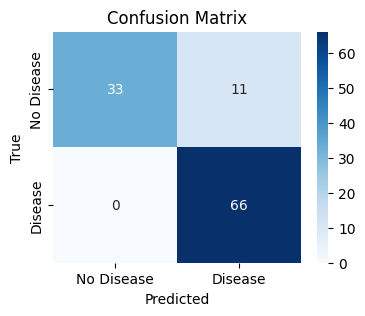

In [34]:
import seaborn as sns

# Evaluate the model on the testing data
pca.fit_transform(X_train)
X_test = pca.transform(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
class_names = ["No Disease", "Disease"]
plt.figure(figsize=(4, 3))
sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# test acc 0.9

In [35]:
new_inp_img = cv2.imread(
    r"C:\Lakshmi\college\nafld-detection\us_scan_model\og\52_1_80_5.jpg", cv2.CV_8UC1
)

new_inp_img = new_inp_img.astype(np.uint8)
enhanced_inp_im = enhance_image(new_inp_img)
roi_im = enhanced_inp_im[300:700, 170:800]
new_features = compute_glcm_features(new_inp_img)
new_features_pca = pca.transform([new_features])

In [36]:
model.predict(new_features_pca)

array([0], dtype=uint8)

## CNN Model; 3 crossfold validation

In [37]:
from sklearn.model_selection import train_test_split

X = np.array(df["images"].tolist())
y = np.array(df["class"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as snss
import numpy as np

model = Sequential(
    [
        Conv2D(
            32, (3, 3), activation="relu", input_shape=(X[0].shape[0], X[0].shape[1], 1)
        ),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
print("meo")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])




meo



In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 628, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 314, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 312, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 156, 64)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 978432)            0         
                                                                 
 dense (Dense)               (None, 64)                6

In [40]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

y_pred = model.predict_classes(X_test)

accuracy = accuracy_score(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

cls_report = classification_report(y_test, y_pred)

Epoch 1/10


14/14 [==============================] - 22s 1s/step - loss: 1151.7119 - accuracy: 0.5909
Epoch 2/10
14/14 [==============================] - 57s 4s/step - loss: 2.3900 - accuracy: 0.6568
Epoch 3/10
14/14 [==============================] - 72s 5s/step - loss: 0.5656 - accuracy: 0.7136
Epoch 4/10
14/14 [==============================] - 76s 5s/step - loss: 0.4164 - accuracy: 0.7136
Epoch 5/10
14/14 [==============================] - 80s 6s/step - loss: 0.2854 - accuracy: 0.7136
Epoch 6/10
14/14 [==============================] - 78s 6s/step - loss: 0.2218 - accuracy: 0.7136
Epoch 7/10
14/14 [==============================] - 49s 3s/step - loss: 0.2036 - accuracy: 0.9818
Epoch 8/10
14/14 [==============================] - 59s 4s/step - loss: 0.2006 - accuracy: 1.0000
Epoch 9/10
14/14 [==============================] - 66s 5s/step - loss: 0.1975 - accuracy: 0.9932
Epoch 10/10
14/14 [==============================] - 66s 5s/step - loss: 0.1955 - accuracy: 1.0000


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
import numpy as np


def create_model(input_shape):
    model = Sequential(
        [
            Conv2D(
                32,
                (3, 3),
                activation="relu",
                input_shape=(input_shape[0], input_shape[1], 1),
            ),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )
    return model


num_folds = 3
epochs = 10
batch_size = 32

accuracy_scores = []
loss_scores = []

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(input_shape=X_train[0].shape)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1
    )

    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    loss_scores.append(loss)
    accuracy_scores.append(accuracy)

mean_loss = np.mean(loss_scores)
mean_accuracy = np.mean(accuracy_scores)

print("Mean Loss:", mean_loss)
print("Mean Accuracy:", mean_accuracy)

Epoch 1/10
12/12 [==============================] - 22s 2s/step - loss: 1300.9534 - accuracy: 0.4891
Epoch 2/10
12/12 [==============================] - 30s 2s/step - loss: 27.3765 - accuracy: 0.7760
Epoch 3/10
12/12 [==============================] - 30s 2s/step - loss: 0.1065 - accuracy: 0.9727
Epoch 4/10
12/12 [==============================] - 30s 2s/step - loss: 0.0060 - accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 30s 2s/step - loss: 8.6413e-05 - accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 30s 2s/step - loss: 1.8359e-05 - accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 30s 3s/step - loss: 8.3658e-06 - accuracy: 1.0000
Epoch 8/10
12/12 [==============================] - 30s 3s/step - loss: 5.4296e-06 - accuracy: 1.0000
Epoch 9/10
12/12 [==============================] - 30s 2s/step - loss: 3.8207e-06 - accuracy: 1.0000
Epoch 10/10
6/6 [==============================] - 4s 559ms/step - loss: 0.3322 - accuracy: 0.

In [42]:
y_pred_probs = model.predict(X_test)

y_pred_classes = (y_pred_probs > 0.5).astype(int)

4/4 [==============================] - 2s 512ms/step


In [43]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

4/4 - 2s - loss: 0.0097 - accuracy: 1.0000 - 2s/epoch - 508ms/step


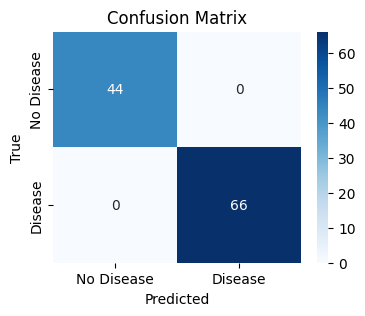

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["No Disease", "Disease"]
mean_conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(4, 3))
sns.heatmap(
    mean_conf_matrix,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [45]:
print(roc_auc_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        66

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110

